In [1]:
# import Pkg
# Pkg.add("Interpolations")
# Pkg.add("Images")

using Markdown
using InteractiveUtils

# This Pluto notebook uses @bind for interactivity. When running this notebook outside of Pluto,
# the following 'mock version' of @bind gives bound variables a default value (instead of an error).
macro bind(def, element)
    quote
        local el = $(esc(element))
        global $(esc(def)) = Core.applicable(Base.get, el) ? Base.get(el) : missing
        el
    end
end

using WaterLily, StaticArrays, Interpolations, Plots, Images

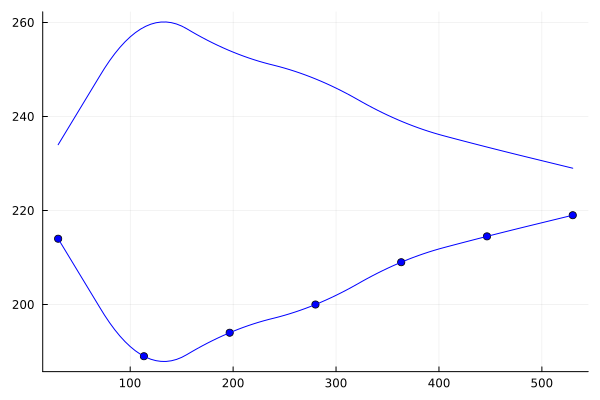

In [2]:
md"""

### Modeling the shark's thickness and motion

We'll define the thickness and motion distributions using `interpolate` to fit splines
through a few points.
"""

fit = y-> scale(interpolate(y, BSpline(Quadratic(Line(OnGrid())))), range(0,1,length=length(y)))

# Fish shape
# begin
# 	url2 = "https://pterosaurheresies.files.wordpress.com/2020/01/squalus-acanthias-invivo588.jpg"
# 	filename2 = download(url2)
# 	dogfish = load(filename2)
# end

md"""
The bottom view shows the outline we're interested in, and adding a few points along
the length defines the thickness distribution function `thk`.
"""

begin
    plot()
	# plot(dogfish)
	nose,len = (30,224),500
	width = [0.02,0.07,0.06,0.048,0.03,0.019,0.01]
	scatter!(nose[1].+len.*range(0,1,length=length(width)), 
		nose[2].-len.*width,color=:blue,legend=false)
	thk = fit(width)
	x = 0:0.01:1
	plot!(nose[1].+len.*x, [nose[2].-len.*thk.(x),nose[2].+len.*thk.(x)],color=:blue)
end

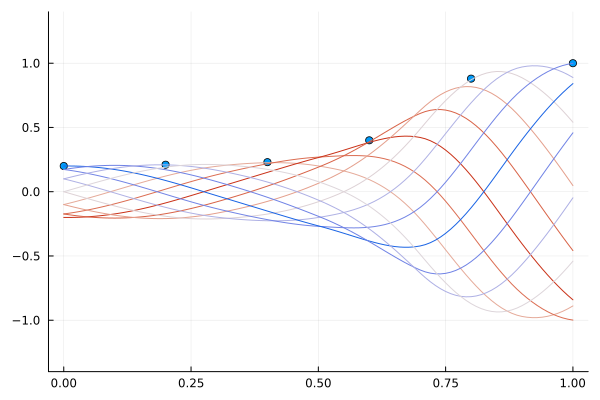

In [3]:
md"""
Looking at [videos of swimming dogfish](https://youtu.be/nMa6lD2CQVI?t=200),
we can see a couple general features
 - The motion of the front half of the body has a small amplitude (around 20% of the tail).
This sets the amplitude evelope for the traveling wave.
"""
begin
	envelope = [0.2,0.21,0.23,0.4,0.88,1.0]
	amp = fit(envelope)
end

md"""
- The wavelength of the traveling wave is a bit longer than the body length. 

The slider below controls the wavelength of the traveling wave λ, which you can
adjust to see the impact it has on the backbone over the motion cycle.
"""

#md"λ: $@bind λ Slider(0.5:0.1:2, show_value=true, default = 1.1)"

λ = 1.1
begin
	scatter(0:0.2:1, envelope)
	colors = palette(:cyclic_wrwbw_40_90_c42_n256)
	for t in 1/12:1/12:1
		plot!(x,amp.(x).*sin.(2π/λ*x.-2π*t),color=colors[floor(Int,t*256)])
	end
	plot!(ylim=(-1.4,1.4),legend=false)
end

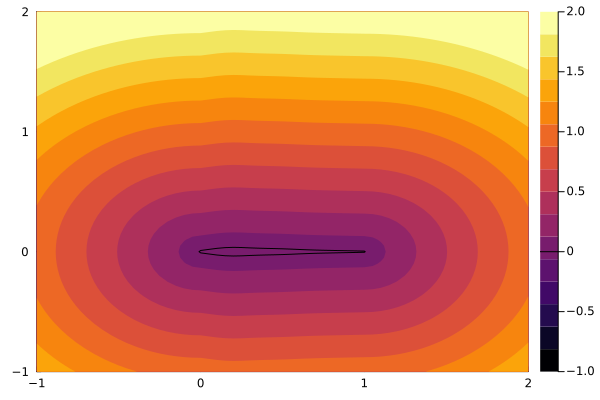

In [4]:
md"""

### Setting up the simulation

Now the thickness and motion are defined, but how will we apply these to a fluid simulation?
`WaterLily`uses an [immersed boundary method](https://eprints.soton.ac.uk/369635/) and
[automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) to
embed a body into the flow. The upshot is that we don't need to do any meshing; all we
need is a signed distance function (SDF) to the surface.

Let's start by defining the SDF to the "backbone", which is a line segment from $x=0\ldots 1$.
[See this great video from Inigo Quilez for a derivation of this sdf.]
(https://www.youtube.com/watch?v=PMltMdi1Wzg)
The plot below shows the sdf and the zero contour, which is ... just a line segment. 

Simple adjustments to the SDF give us more control of the shape and position. By shifting the y offset as
`y = y-shift`, we can move the body laterally. And by subtracting a thickness from the distance as
`sdf = sdf-thickness`, we can give the line some width. This is all we need to model the shark.
"""
T = 0.5
begin
	function segment_sdf(x,y) 
		s = clamp(x,0,1)         # distance along the segment
		# y = y-shift              # shift laterally
		y = y+0              # shift laterally
		sdf = √sum(abs2,(x-s,y)) # line segment SDF
		return sdf-T*thk(s)      # subtract thickness
	end
	grid = -1:0.05:2
	contourf(grid,grid,segment_sdf,clim=(-1,2),linewidth=0)
	contour!(grid,grid,segment_sdf,levels=[0],color=:black) # zero contour
end

In [5]:
md"""
With the basic SDF tested out, we are ready to set up the WaterLily simulation using
the function `fish` defined below:
 - The functions `thk` is passed in to create the `sdf` and the function `amp` is
passed in to create the traveling wave `map`.
 - The only numerical parameter passed into `fish` is the length of the fish `L`
measured in computational cells. This sets the resolution of the simulation and
the size of the fluid arrays.
 - The other parameters are the tail amplitude `A` as a fraction of the length,
the [Stouhal number](https://en.wikipedia.org/wiki/Strouhal_number) which sets
the motion frequency `ω`, and the [Reynolds number](https://en.wikipedia.org/wiki/Reynolds_number)
which sets the fluid viscosity `ν`.
"""

begin
	function fish(thk,amp,k=5.3;L=2^6,A=0.1,St=0.3,Re=1e4)
		# fraction along fish length
		s(x) = clamp(x[1]/L,0,1)
		
		# fish geometry: thickened line SDF
		sdf(x,t) = √sum(abs2,x-L*SVector(s(x),0.))-L*thk(s(x))

		# fish motion: travelling wave
		U=1
		ω = 2π*U/(L) * St/(2A)
		function map(x,t)
			xc = x.-L # shift origin
			return xc-SVector(0.,A*L*amp(s(xc))*sin(k*s(xc)-ω*t))
		end
		
		# make the fish simulation
		return Simulation((4L+2,2L+2),[U,0.],L;
							ν=U*L/Re,body=AutoBody(sdf,map))
	end
	
	# Create the swimming shark
	L,A,St = 3*2^5,0.1,0.3
	swimmer = fish(thk,amp;L,A,St);
	
	# Save a time span for one swimming cycle
	period = 2A/St
	cycle = range(0,23/24*period,length=24)
end


0.0:0.02777777777777778:0.638888888888889

[ Info: Saved animation to C:\Users\alidtke\Documents\tmp.gif


Plots.AnimatedGif("C:\\Users\\alidtke\\Documents\\tmp.gif")
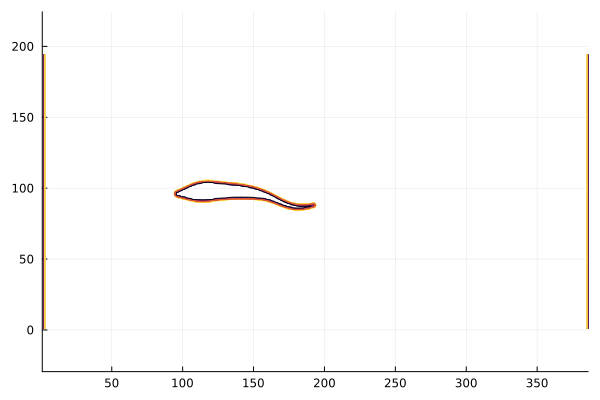

In [9]:
md"""
We can test our geometry by plotting the immersed boundary function `μ₀`; which equals
1 in the fluid and 0 in the body. 
"""

@gif for t ∈ cycle
	measure!(swimmer,t*swimmer.L/swimmer.U);
	contour(swimmer.flow.μ₀[:,:,1]',
		aspect_ratio=:equal,legend=false)#,border=:none)
end

[ Info: Saved animation to C:\Users\alidtke\Documents\tmp.gif


Plots.AnimatedGif("C:\\Users\\alidtke\\Documents\\tmp.gif")
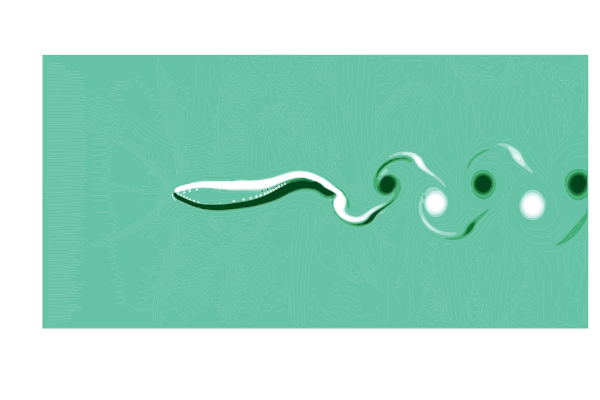

In [7]:
md"""

### Running visualizing and measuring the simulation

That animation of the motion looks great, so we are ready to run the flow simulator! 

The `sim_step!(sim,t,remeasure=true)` function runs the simulator up to time `t`,
remeasuring the body position every time step. (`remeasure=false` by default since it
takes a little extra computational time and isn't needed for statics geometries.)
"""

# run the simulation a few cycles (this takes few seconds)
begin 
	sim_step!(swimmer,3,remeasure=true)
	sim_time(swimmer)
end

md"""
The simulation has now run forward in time, but there are no visualizations or measurements by default. 

To see what is going on, lets make a gif of the vorticity `ω=curl(u)` to visualize the
vortices in the wake of the shark. This requires simulating a cycle of motion,
and computing the `curl` at all the points `@inside` the simulation. 
"""

begin
	# plot the vorcity ω=curl(u) scaled by the body length L and flow speed U
	function plot_vorticity(sim)
		@inside sim.flow.σ[I] = WaterLily.curl(3,I,sim.flow.u)*sim.L/sim.U
		contourf(sim.flow.σ', 
			color=palette(:BuGn), clims=(-10,10),linewidth=0,
			aspect_ratio=:equal,legend=false,border=:none)
	end

	# make a gif over a swimming cycle
	@gif for t ∈ sim_time(swimmer).+cycle
		sim_step!(swimmer,t,remeasure=true)
		plot_vorticity(swimmer)
	end
end


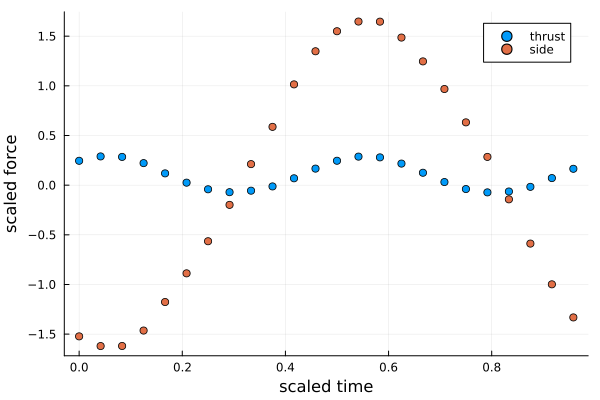

In [8]:

md"""
This is pretty (CFD does stand for _Colorful Fluid Dynamics_ after all), but also
tells us something important about the flow. Notice that there are no eddies coming
off the body anywhere other than the tail! This is a sign of efficiency since energy
is only used to create those trailing vortices.

We can dig in and get some quantitative measurements from the simulation as well.
The function `∮nds` takes a integral over the body surface. By passing in the pressure `p`,
we can measure the thrust force and side force generated by the shark!
"""

begin
	function get_force(sim,t)
		sim_step!(sim,t,remeasure=true)
		return WaterLily.∮nds(sim.flow.p,sim.body,t*sim.L/sim.U)./(0.5*sim.L*sim.U^2)
	end
	forces = [get_force(swimmer,t) for t ∈ sim_time(swimmer).+cycle]
	"got forces"
end

scatter(cycle./period,[first.(forces),last.(forces)], 
	labels=permutedims(["thrust","side"]), 
	xlabel="scaled time", ylabel="scaled force")